In [1]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 KB 642.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 KB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 KB 5.6 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
  

Importam librariile necesare:

In [2]:
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import math
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
plt.style.use('classic')

Luam datele corespunzatoare pretului actiunilor companiei:

In [24]:
company = 'TSLA'
end = datetime(2023, 1, 11)
start = datetime(2012, 1, 1)

df = yf.download(tickers=company, start=start, end=end)
print(df)
print(df.shape)

[*********************100%***********************]  1 of 1 completed
                                 Open        High         Low       Close  \
Date                                                                        
2012-01-03 00:00:00-05:00    1.929333    1.966667    1.843333    1.872000   
2012-01-04 00:00:00-05:00    1.880667    1.911333    1.833333    1.847333   
2012-01-05 00:00:00-05:00    1.850667    1.862000    1.790000    1.808000   
2012-01-06 00:00:00-05:00    1.813333    1.852667    1.760667    1.794000   
2012-01-09 00:00:00-05:00    1.800000    1.832667    1.741333    1.816667   
...                               ...         ...         ...         ...   
2023-01-04 00:00:00-05:00  109.110001  114.589996  107.519997  113.639999   
2023-01-05 00:00:00-05:00  110.510002  111.750000  107.160004  110.339996   
2023-01-06 00:00:00-05:00  103.000000  114.389999  101.809998  113.059998   
2023-01-09 00:00:00-05:00  118.959999  123.519997  117.110001  119.769997   
2023-01

Vizualizam istoria pretului maxim al actiunii din fiecare zi:

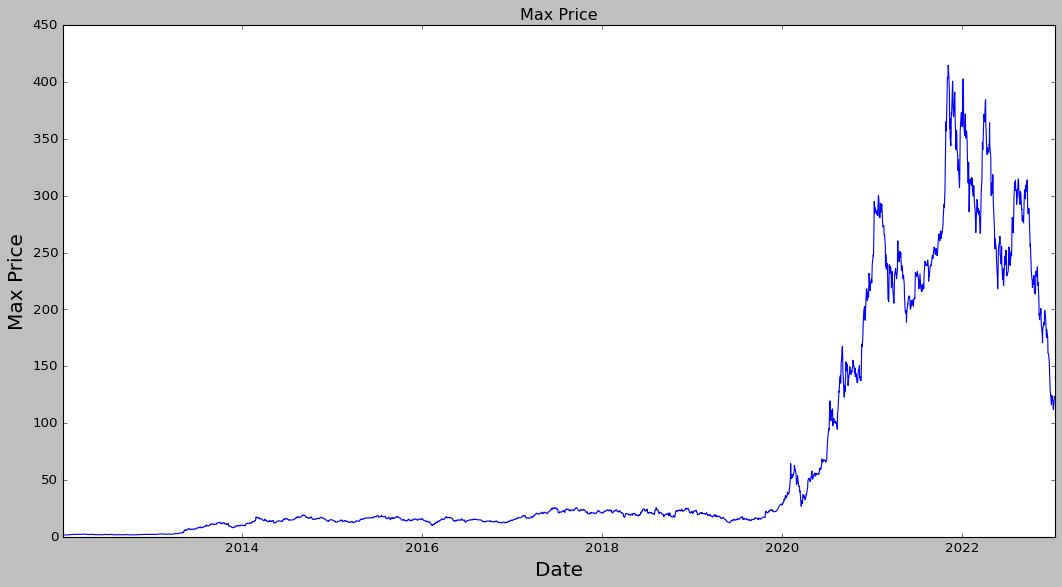

In [25]:
plt.figure(figsize=(16, 8))
plt.title('Max Price')
plt.plot(df['High'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Max Price', fontsize=18)
plt.show()

Cream un nou dataframe doar cu coloana 'High', corespunzatoare pretului maxim din fiecare zi

In [26]:
data = df.filter(['High'])
dataset = data.values
print(dataset)

[[  1.96666706]
 [  1.91133296]
 [  1.86199999]
 ...
 [114.38999939]
 [123.51999664]
 [122.76000214]]


Antrenam modelul pe 82% din date

In [27]:
training_data_len = math.ceil(len(dataset) * 0.82)
print(training_data_len)

2275


Scalam datele pentru a fi in intervalul [0, 1]

In [28]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
print(scaled_data)

[[4.28069390e-04]
 [2.93993315e-04]
 [1.74458111e-04]
 ...
 [2.72832999e-01]
 [2.94955242e-01]
 [2.93113753e-01]]


Cream setul de date pentru antrenat:
x_train vor fi "training features", iar y_train vor fi "target features"

In [29]:
train_data = scaled_data[0: training_data_len]
#print(train_data)
x_train = []
y_train = []
for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i, 0])

#print(x_train)
#print(y_train)

Convertim x_train si y_train sa fie array-uri din numpy

In [30]:
x_train, y_train = np.array(x_train), np.array(y_train)
#print(x_train)
#print(y_train)

Construim modelul LSTM

In [31]:
model = Sequential()
model.add(Dense(32, input_shape=(x_train.shape[1],), activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))

Compilam si antrenam modelul

In [32]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [33]:
model.fit(x_train, y_train, batch_size=1, epochs=1)

2215/2215 [==============================] - 4s 2ms/step - loss: 3.9171e-04


Cream setul de date pentru test

In [34]:
test_data = scaled_data[training_data_len - 60:]
#print(test_data)
x_test = []
y_test = dataset[training_data_len:] #valorile pe care vrem sa le prezica
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

Convertim datele sa fie sub forma de array numpy

In [35]:
x_test = np.array(x_test)
print(x_test.shape)

(499, 60)


Luam valorile de pret prezise de model

In [36]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions) #facem un unscale la valori, astfel incat sa contina valori 

16/16 [==============================] - 0s 2ms/step


Luam root mean squred error

In [37]:
rmse = np.sqrt(np.mean(predictions - y_test)**2)
print(rmse)

50.449077766739535


Afisam datele

<ipython-input-39-8fab107ca1e1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


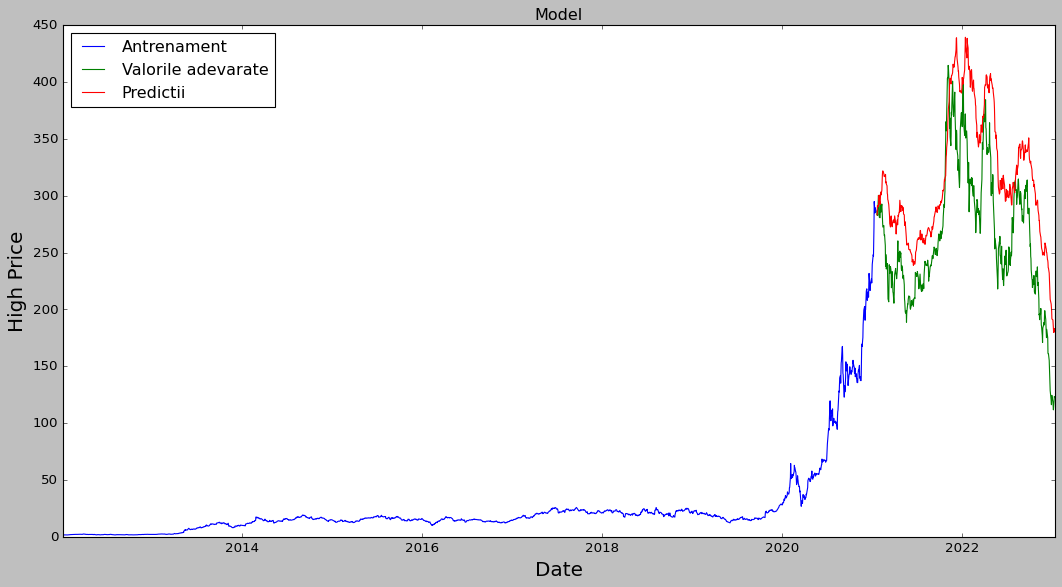

                                 High  Predictions
Date                                              
2021-01-19 00:00:00-05:00  283.333344   283.089233
2021-01-20 00:00:00-05:00  286.500000   284.012756
2021-01-21 00:00:00-05:00  285.239990   291.324585
2021-01-22 00:00:00-05:00  282.666656   290.747375
2021-01-25 00:00:00-05:00  300.133331   290.290955
...                               ...          ...
2023-01-04 00:00:00-05:00  114.589996   186.955261
2023-01-05 00:00:00-05:00  111.750000   182.555542
2023-01-06 00:00:00-05:00  114.389999   179.828308
2023-01-09 00:00:00-05:00  123.519997   183.127350
2023-01-10 00:00:00-05:00  122.760002   180.385284

[499 rows x 2 columns]


In [39]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Vizualizam datele
plt.figure(figsize=(16, 8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('High Price', fontsize=18)
plt.plot(train['High'])
plt.plot(valid[['High', 'Predictions']])
plt.legend(['Antrenament', 'Valorile adevarate', 'Predictii'], loc='upper left')
plt.show()
print(valid)

Incercam sa prezicem valoarea pentru ziua urmatoare



In [40]:
print(x_test)
print(x_test.shape)

[[0.34534616 0.35526444 0.33722094 ... 0.69064387 0.69268726 0.69018349]
 [0.35526444 0.33722094 0.33953897 ... 0.69268726 0.69018349 0.68218752]
 [0.33722094 0.33953897 0.34336736 ... 0.69018349 0.68218752 0.68986042]
 ...
 [0.54266145 0.52703292 0.5359739  ... 0.28351856 0.2733176  0.26643621]
 [0.52703292 0.5359739  0.54389718 ... 0.2733176  0.26643621 0.272833  ]
 [0.5359739  0.54389718 0.53323587 ... 0.26643621 0.272833   0.29495524]]
(499, 60)


In [41]:
df2 = yf.download(tickers=company, start=start, end=end)
high_df = df2.filter(['High'])
#luam valorile din ultimele 60 zile si convertim df in array



last_60_days = high_df[-60:].values
#scalam datele sa fie intre 0 si 1
last_60_days_scaled = scaler.transform(last_60_days)

X_test = [day[0] for day in last_60_days_scaled]
X_test = np.array([X_test])

pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 18ms/step
[[177.44388]]


In [42]:
df3 = yf.download(tickers=company, start=end, end=end + timedelta(days=1))
print(df3.filter(['High']))

[*********************100%***********************]  1 of 1 completed
                                 High
Date                                 
2023-01-11 00:00:00-05:00  125.949997
